In [58]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import optuna
from optuna.visualization import plot_slice

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input

# Task 2

# Task 2.1 – Train more complicated model

For this task I choose two models: neural network and random forest. In general, you can say that neural networks as "generally better everywhere", but it is known that decision trees are very good at classificaion. So, we will compare :)

Before we start we once again prepare dataset

In [ ]:
data = pd.read_csv("apple_quality.csv")
data.drop([data.shape[0]-1], inplace=True)
data.drop(columns=data.columns[0], axis=1, inplace=True)

data["Acidity"] = data["Acidity"].astype(float)
data['Quality'].replace({"bad":0, "good":1}, inplace=True)

features = data.drop(columns="Quality", axis=1)
scaler = StandardScaler().fit(features.values)
features_scaled = pd.DataFrame(scaler.transform(features.values), columns=features.columns)

X_train, X_test, y_train, y_test = train_test_split(features_scaled, data["Quality"], random_state = 1024)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state = 1024)

And set hyperparameters that we will not optimize.

In [38]:
# fixed random seed for tensorflow
tf.random.set_seed(1024)

# number of neurons in the input and output layers. n_input = n_features, n_output = 1 since we have only 1 number as an output (we have classification w 2 classes)
n_input = np.shape(X_train)[1]
n_output = 1

# number of epochs to train NN
epochs = 50

Then we create optuna objective function to find best classifier and best hyperparameters for him.

Hyperparameters for NN:
1) number of hidden layers (from 1 to 4);
2) number of neurons in each hidden layer (from 2 to 30);
3) learning rate (from 0.01 to 0.1).
    
As a loss function we use binary cross-entropy since we have classificaion task. We also use [Adam](https://arxiv.org/abs/1412.6980) optimizer for faster learning.

Hyperparameters for Random Forest:
1) number of estimators;
2) depth of each estimator.

We want optuna to maximize $F_2$ score.

In [39]:
def objective(trial):
    model_type = trial.suggest_categorical("classifier", ["neural_network", "random_forest"])
    
    if model_type == "neural_network":
        num_layers = trial.suggest_int("num_layers", 1, 4)
        n_hidden = trial.suggest_int("n_hidden", 2, 30)
        learning_rate = trial.suggest_float("learning_rate", 0.01, 0.1)

        tf.keras.backend.clear_session()
        model = Sequential([
                Input(n_input),
            ])

        for ind in range(num_layers):
            model.add(Dense(n_hidden, activation='relu'))
        model.add(Dense(n_output, name="output_layer"))
        
        model.compile(
            loss = tf.keras.losses.BinaryCrossentropy(), optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
        )
        
        model.fit(X_train, y_train, epochs=epochs, verbose=0)
        y_hat = (model.predict(X_val, verbose=0) > 0.5).astype(int)
    
    else:
        num_classifiers = trial.suggest_int("num_classifiers", 2, 30)
        max_depth = trial.suggest_int("max_depth", 2, 30)
        
        model = RandomForestClassifier(n_estimators = num_classifiers, max_depth = max_depth, random_state=1024, verbose=0)
        model.fit(X_train, y_train)
        y_hat = model.predict(X_val)
    
    return fbeta_score(y_hat, y_val, beta=2)

In [24]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2024-02-22 19:27:23,301] A new study created in memory with name: no-name-08bf23ed-702d-4c4e-8ee8-0f827a5c6c1f
[I 2024-02-22 19:27:28,416] Trial 0 finished with value: 0.8058345289335246 and parameters: {'classifier': 'neural_network', 'num_layers': 2, 'n_hidden': 28, 'learning_rate': 0.030762695901187007}. Best is trial 0 with value: 0.8058345289335246.
[I 2024-02-22 19:27:28,461] Trial 1 finished with value: 0.7633221315410467 and parameters: {'classifier': 'random_forest', 'num_classifiers': 10, 'max_depth': 4}. Best is trial 0 with value: 0.8058345289335246.
[I 2024-02-22 19:27:28,492] Trial 2 finished with value: 0.8338092518560822 and parameters: {'classifier': 'random_forest', 'num_classifiers': 4, 'max_depth': 29}. Best is trial 2 with value: 0.8338092518560822.
[I 2024-02-22 19:27:28,571] Trial 3 finished with value: 0.8552958727001492 and parameters: {'classifier': 'random_forest', 'num_classifiers': 13, 'max_depth': 26}. Best is trial 3 with value: 0.8552958727001492.
[I 

Let's check the results...

In [40]:
# somehow without .show() hothing works...
plot_slice(study).show(renderer="browser")

So, the random forest once again beat the neural network in classification problem :)

From the first plot we can see that best random forest is better that best NN for almost 0.1.

In [41]:
study.best_trial

FrozenTrial(number=14, state=TrialState.COMPLETE, values=[0.8684347373894955], datetime_start=datetime.datetime(2024, 2, 22, 19, 27, 47, 460393), datetime_complete=datetime.datetime(2024, 2, 22, 19, 27, 47, 637483), params={'classifier': 'random_forest', 'num_classifiers': 30, 'max_depth': 23}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'classifier': CategoricalDistribution(choices=('neural_network', 'random_forest')), 'num_classifiers': IntDistribution(high=30, log=False, low=2, step=1), 'max_depth': IntDistribution(high=30, log=False, low=2, step=1)}, trial_id=14, value=None)

Then we create our final classificator using the best results from optuna

In [49]:
model = RandomForestClassifier(n_estimators = 30, max_depth = 23, random_state=1024, verbose=0)
model.fit(X_train, y_train)
y_hat = model.predict(X_test)
print(f"For best classifier, F_2 = {round(fbeta_score(y_hat, y_test, beta=2), 2)}. Baseline F_2 = 0.73 .")

For best classifier, F_2 = 0.87. Baseline F_2 = 0.73 .


## Task 2.2 – interpretation of the model

Because best model is Random Forest, interpretation is not so hard. To start, let's see what feature is most important based on the decrease in impurity.

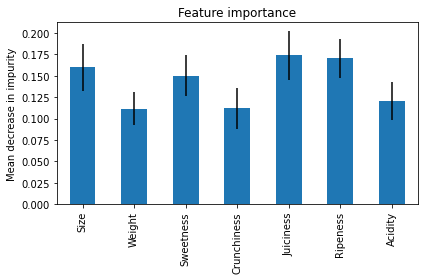

In [65]:
importances = model.feature_importances_

std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

forest_importances = pd.Series(importances, index=X_train.columns.tolist())
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importance")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

We can see that size, juiciness and ripeness are most important features. It is interesting that size is much more important that weight, actually... These two should be connected because density of apple is roughly same...

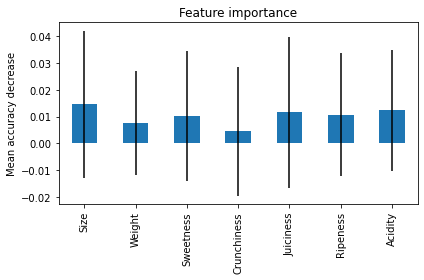

In [67]:
ftwo_scorer = make_scorer(fbeta_score, beta=2)
importances = permutation_importance(model, X_test, y_test, scoring=ftwo_scorer, random_state=1024, n_repeats=10)

std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

forest_importances = pd.Series(importances['importances_std'], index=X_train.columns.tolist())
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importance")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()

So, size is one of the most important as in the previous figure. But here we see that acidity, which was one of the most unimportant features in the MDI, now is the one of the most important weatures. However, from both MDI and permutations we see that all features are more or less important equally

## Final words

In [ ]:
So, to be honest, I am feeling myself kinda strange about the dataset. It is too "good" sometimes and gives strange results..